In [1]:
library('gamCopula')
library('ggplot2')
library('mgcv')
library('pacotest')

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 75)

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



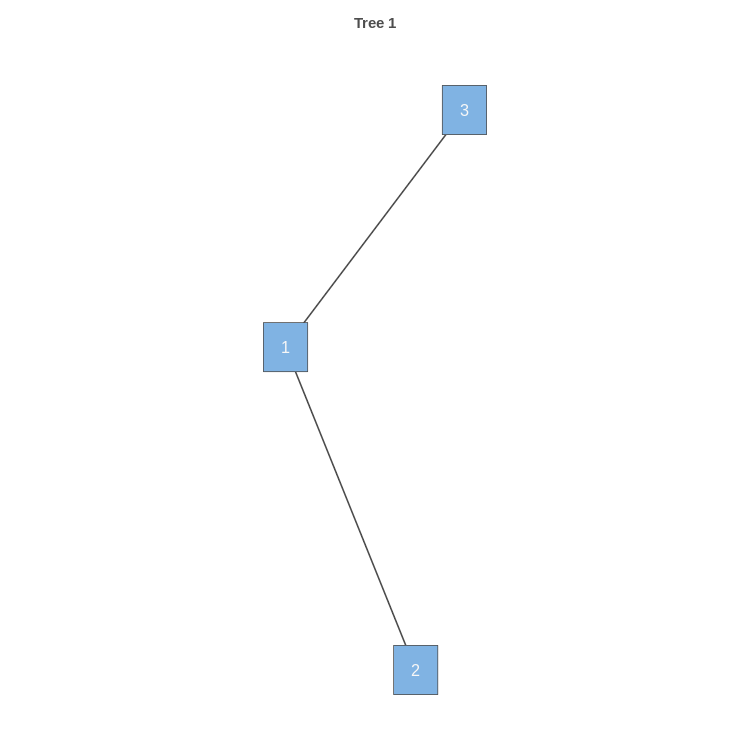

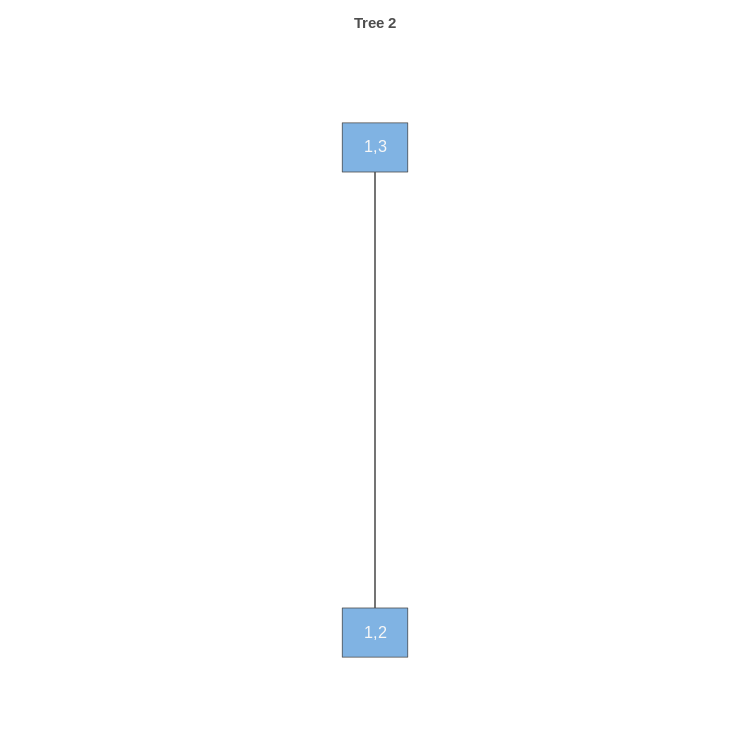

In [2]:
library('VineCopula')

Matrix <- c(2,3,1,
            0,3,1,
            0,0,1)

Matrix <- matrix(Matrix,3,3)
plot(RVineMatrix(Matrix = Matrix))

#dep.functions <- list(function(x) {return ((sin(5*pi*x^2)))},
#                     function(x) {return ((-cos(5*pi*x)- 2*exp(x)))},
#                     function(x) {return (exp(x)-4*x)})

#par(mfrow = c(3,1))
#for (i in 1:length(dep.functions)) {
#    plot(dep.functions[[i]], xlim = c(0,1), col = 'blue')
#}

GAM-Vine matrix: 
     [,1] [,2] [,3]
[1,]    2    0    0
[2,]    3    3    0
[3,]    1    1    1

 Where 
1  <->  X1 
2  <->  X2 
3  <->  X3 

 Tree 1: 
X2,X1: Gaussian with par=0.75 (tau=0.54) 
X3,X1: t with par=-0.33 and par2=301 (tau=-0.21) 

 Tree 2: 
X2,X3|X1 : t copula with tau(z) = (exp(z)-1)/(exp(z)+1) where 
Formula: 
 y ~ X1 
  
 Parametric coefficients: 
             Estimate Std. Error t value Pr(>|t|)     
 (Intercept)        3          0     Inf   <2e-16 *** 
 X1               -10          0    -Inf   <2e-16 *** 
 --- 
 Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
  
  
 R-sq.(adj) =      1   Deviance explained =  100% 
 GCV =      0  Scale est. = 0         n = 100 


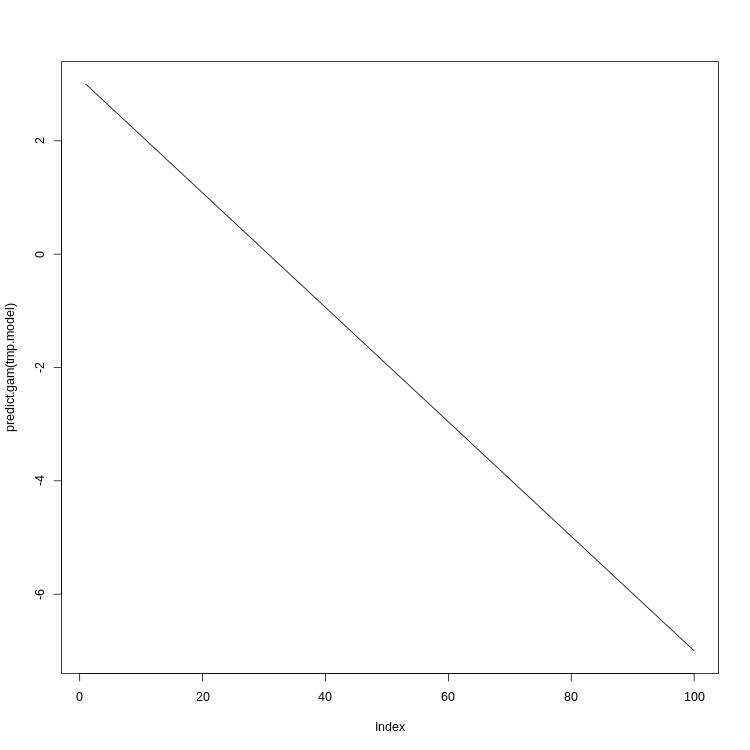

In [3]:
d <- 3    #d dimensional vine specified above
models <- vector(mode = 'list', length = d*(d-1)/2)
#eta0 <- 1
dep.fct <- function(x) {return (3 - 10*x)}
data <- data.frame(u1 = runif(1e2), u2 = runif(1e2), matrix(runif(1e2 * d), 1e2, d))

#Model specification

#First Tree
models[[1]]$family <- 1 #Gaussian
models[[2]]$family <- 2 #T-Copula

models[[1]]$par <- 0.75
models[[2]]$par <- -0.33
models[[2]]$par2 <- 301

n.cov <- 100 #n covariates

#Conditional Copula on Second Tree
tmp.x <- seq(0,1,length.out = n.cov)
tmp.y <- mapply(dep.fct, tmp.x)
tmp.data <- data.frame(y = tmp.y, 'X1' = tmp.x)
tmp.formula <- y ~ X1
tmp.model <- gam(tmp.formula, data = tmp.data)
tmp.family <- 2

if (tmp.family ==2){
    tmp.par2 <- 5
    models[[3]] <- gamBiCop(tmp.family, model = tmp.model, par2 = tmp.par2)
} else{
    models[[3]] <- gamBiCop(tmp.family, model = tmp.model)
}


gvine <- gamVine(Matrix, models, names = c('X1','X2','X3'))
summary(gvine)
#plot(gvine,ylim = c(-5, 5))
plot(predict.gam(tmp.model), type = 'l')

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



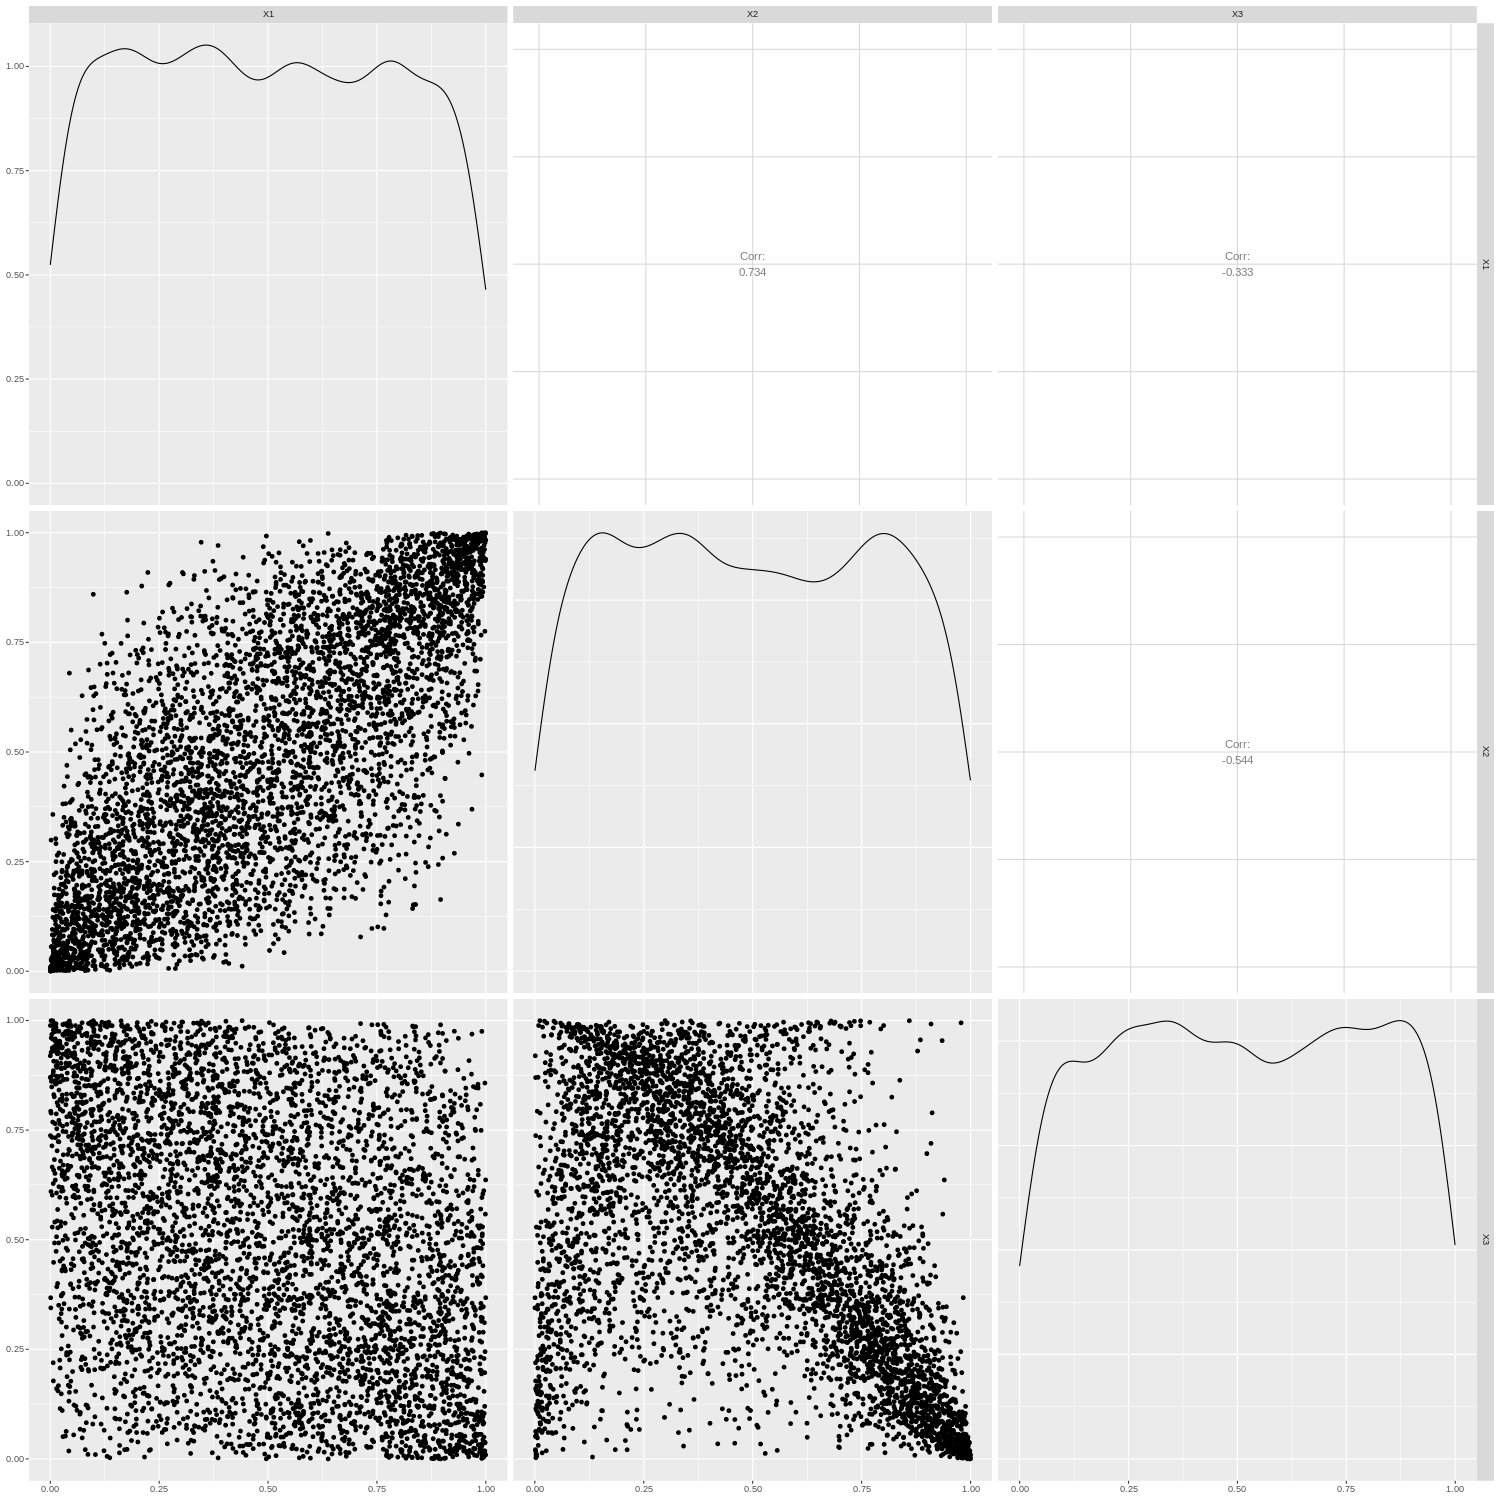

In [4]:
library('GGally')
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 75)
sim.data <- gamVineSimulate(5000,gvine)
ggpairs(data.frame(sim.data))

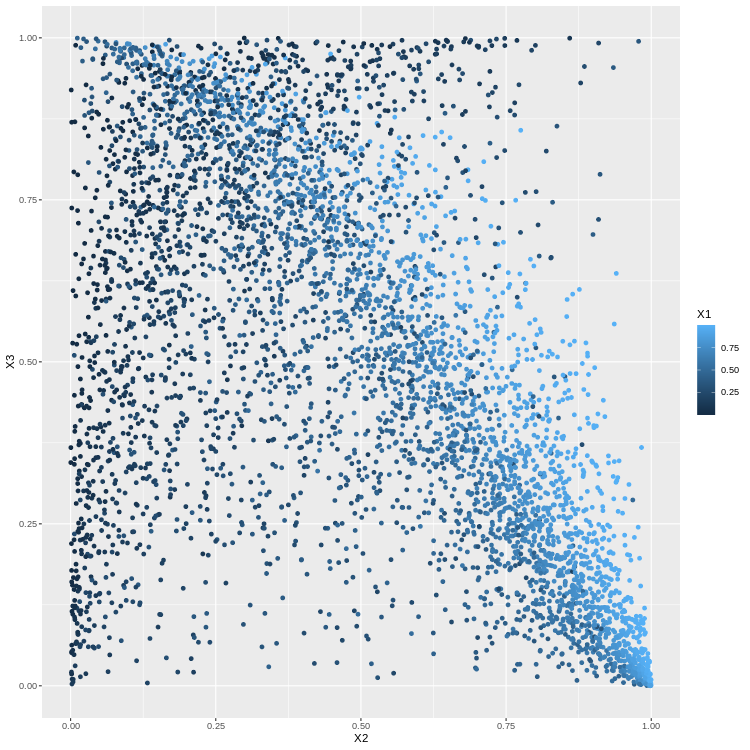

In [5]:
sim.data.df <- data.frame(sim.data)

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 75)

ggplot(sim.data.df, aes(X2,X3, color = X1)) + geom_point()

In [6]:
fit <- gamVineCopSelect(sim.data, Matrix, verbose = TRUE)  #Only the matrix is specified here
fit1 <- gamVineSeqFit(sim.data, gvine, verbose = TRUE)  #the GAMS for individual edges are specified here already
summary(fit)
summary(fit1)

3,1

2,1

2,3|1

3,1

2,1

2,3|1



GAM-Vine matrix: 
     [,1] [,2] [,3]
[1,]    2    0    0
[2,]    3    3    0
[3,]    1    1    1

 Where 
1  <->  X1 
2  <->  X2 
3  <->  X3 

 Tree 1: 
X2,X1: Gaussian with par=0.75 (tau=0.54) 
X3,X1: Gaussian with par=-0.35 (tau=-0.23) 

 Tree 2: 
X2,X3|X1 : t copula with tau(z) = (exp(z)-1)/(exp(z)+1) where 
Formula: 
 z ~ s(X1, k = 20, bs = "cr") 
  
 Parametric coefficients: 
             Estimate Std. Error t value Pr(>|t|)     
 (Intercept) -1.66972    0.01304    -128   <2e-16 *** 
 --- 
 Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
  
 Approximate significance of smooth terms: 
         edf Ref.df    F p-value     
 s(X1) 11.28  13.59 3115  <2e-16 *** 
 --- 
 Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
  
 R-sq.(adj) =  0.894   Deviance explained = 89.5% 
 GCV = 0.74146  Scale est. = 0.73964   n = 5000 
GAM-Vine matrix: 
     [,1] [,2] [,3]
[1,]    2    0    0
[2,]    3    3    0
[3,]    1    1    1

 Where 
1  <->  X1 
2  <->  X2 
3  <->

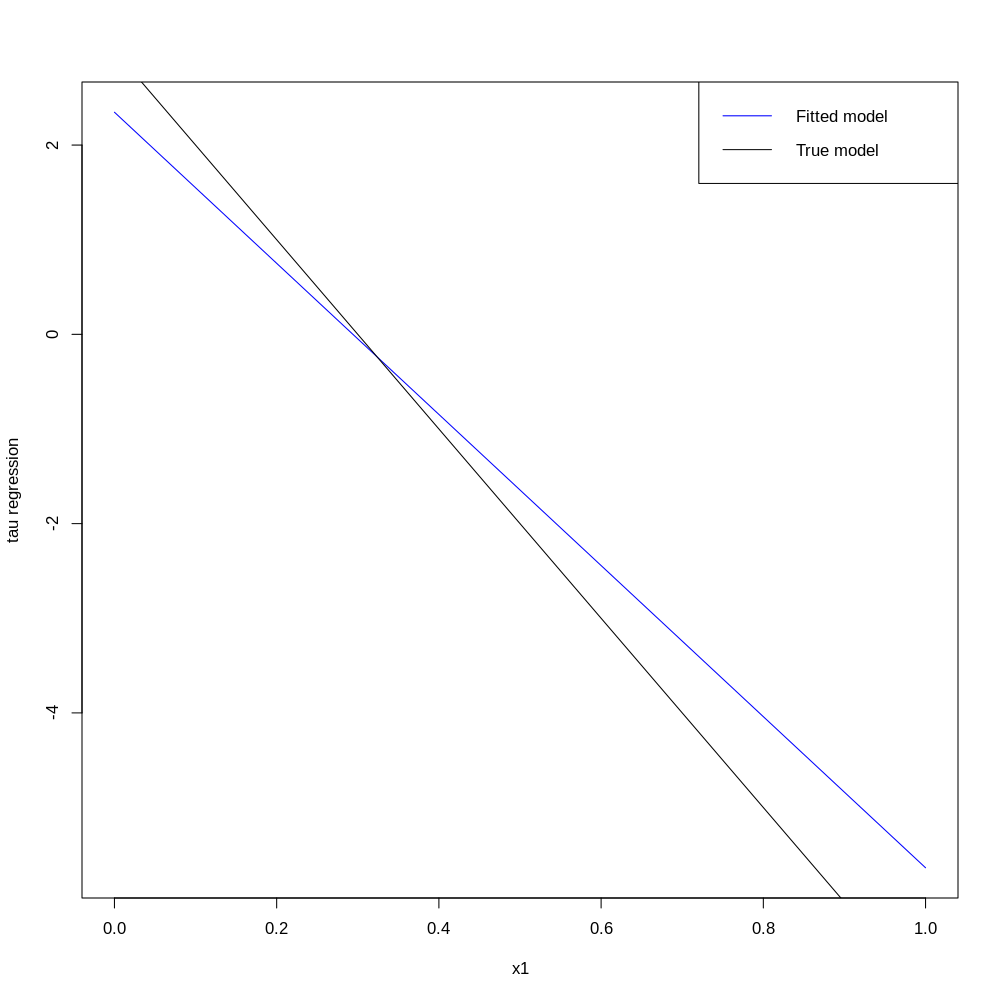

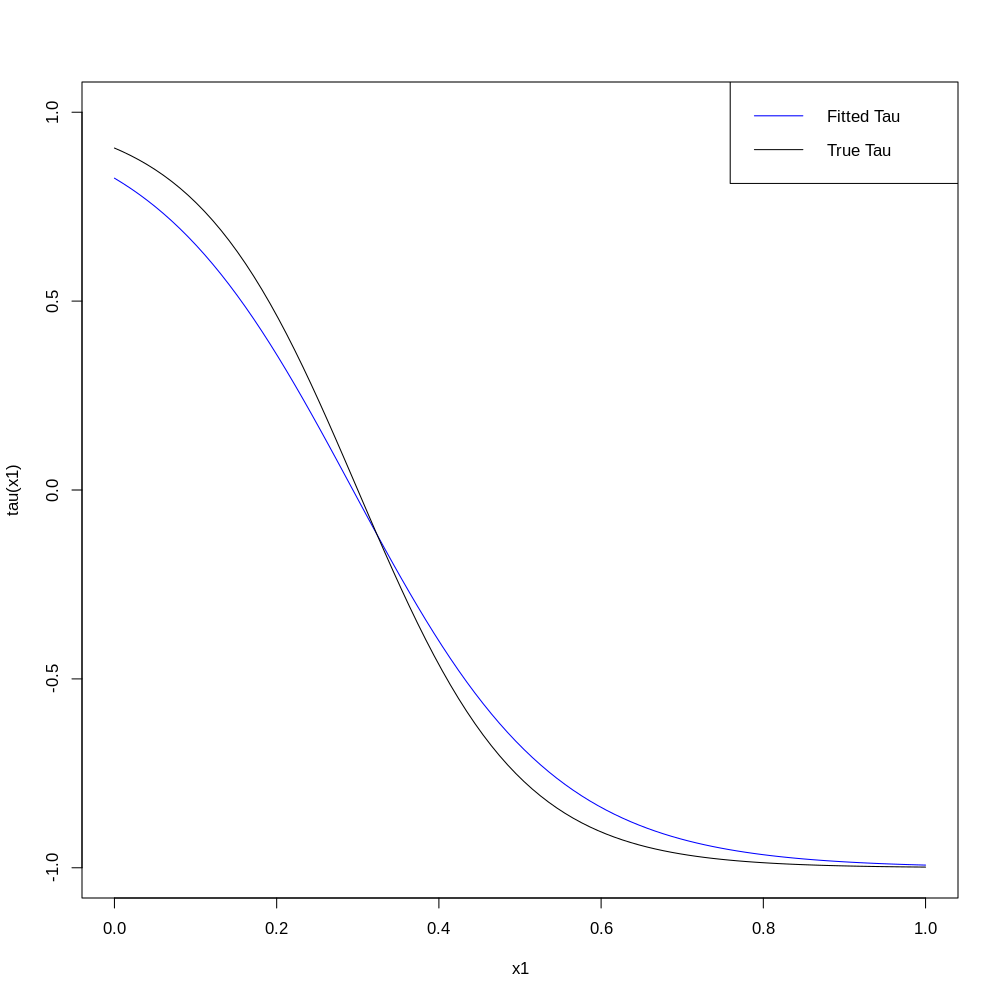

In [7]:
getline_lm <- function(fit){
    intercept <- attr(attr(fit,'model')[[3]],'model')[[1]][[1]]
    slope <- attr(attr(fit,'model')[[3]],'model')[[1]][[2]]
    return(function(x) {intercept + slope*x})
}

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
x <- seq(0,1,length.out = n.cov)
plot(x,getline_lm(fit1)(x), type = 'l', col = 'blue', xlab = 'x1', ylab = 'tau regression')
lines(x,dep.fct(x))
legend('topright', legend = c('Fitted model','True model'), lty = c(1,1), col = c('blue','black'))


linkfct <- function(x) {return ((exp(x)-1)/(exp(x)+1))}
plot(x,linkfct(getline_lm(fit1)(x)), type = 'l', col = 'blue', xlab = 'x1', ylab = 'tau(x1)', ylim = c(-1,1))
lines(x,linkfct(dep.fct(x)))
legend('topright', legend = c('Fitted Tau','True Tau'), lty = c(1,1), col = c('blue','black'))

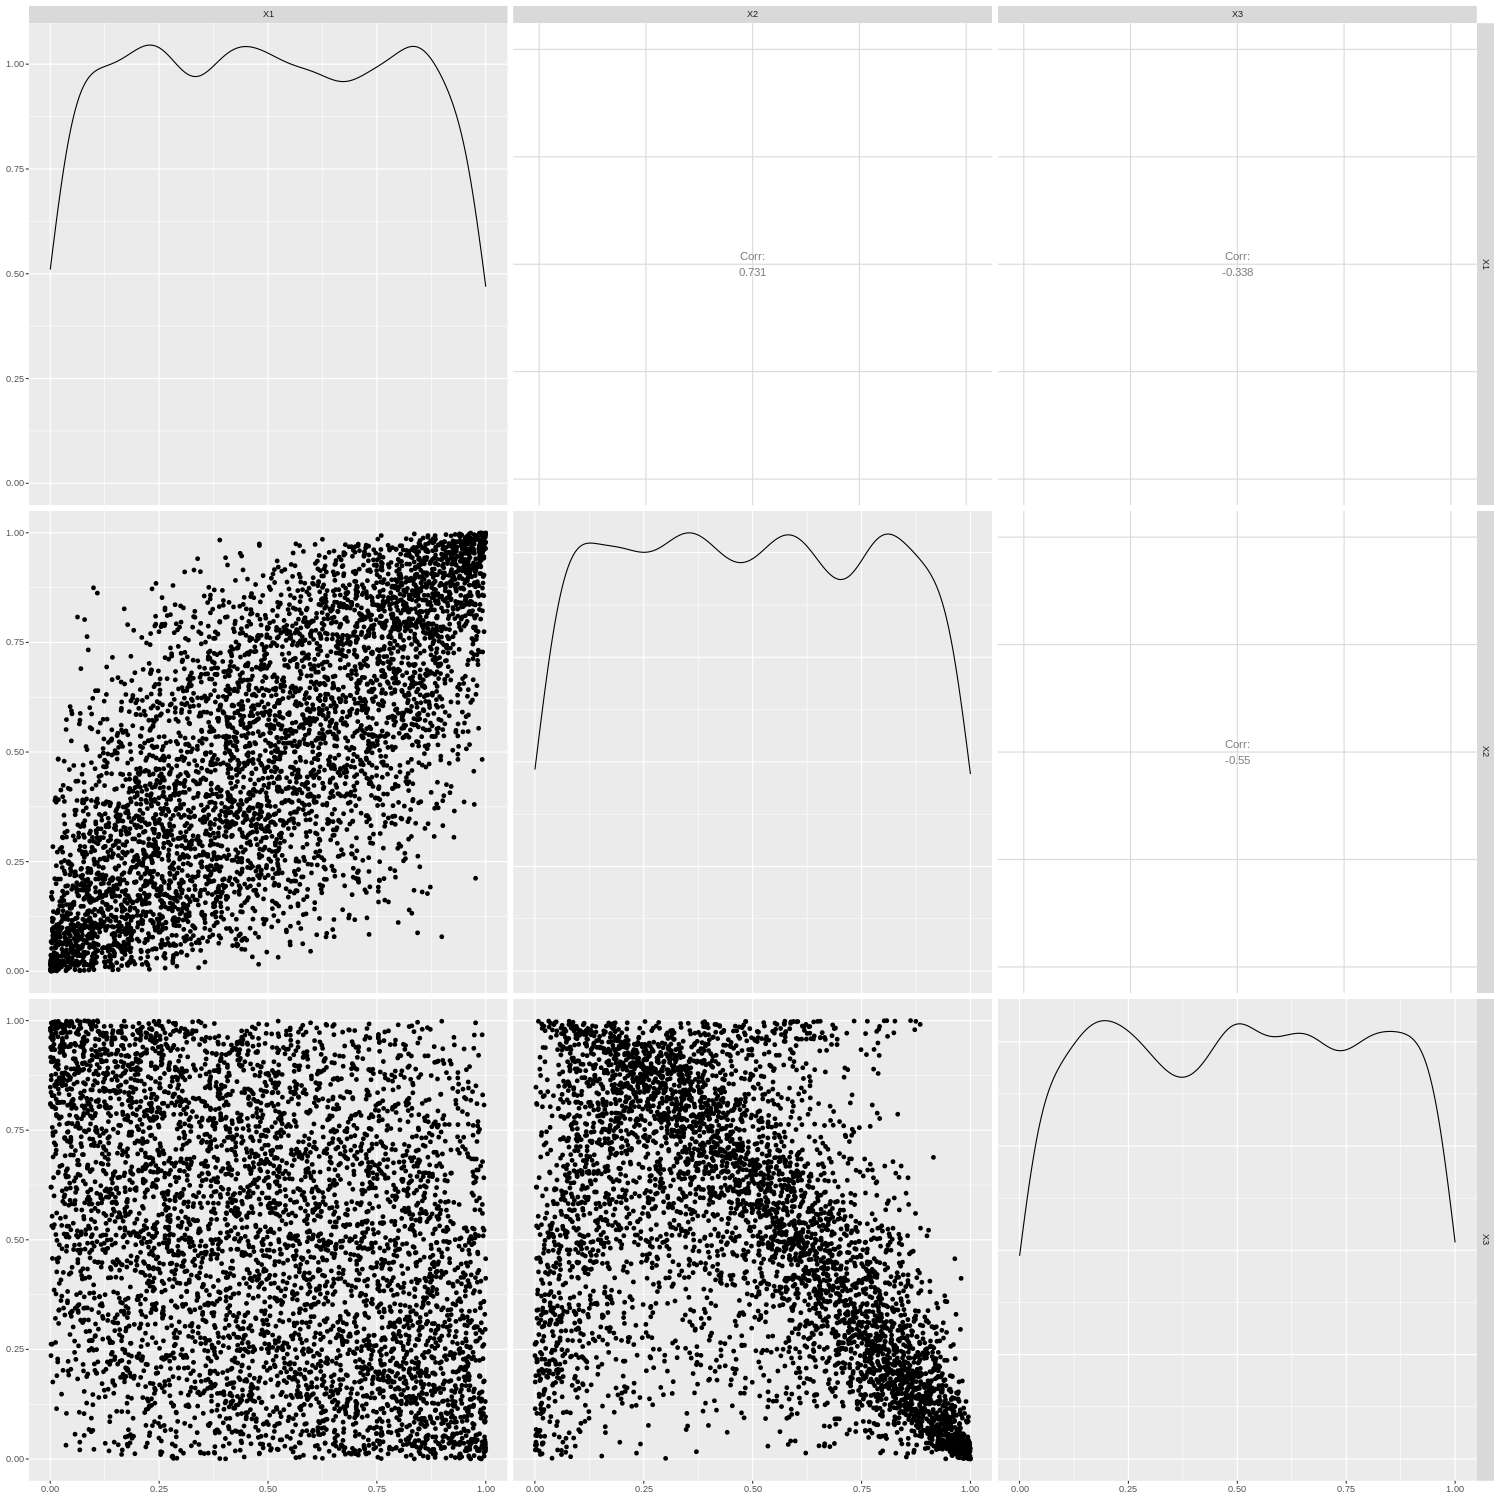

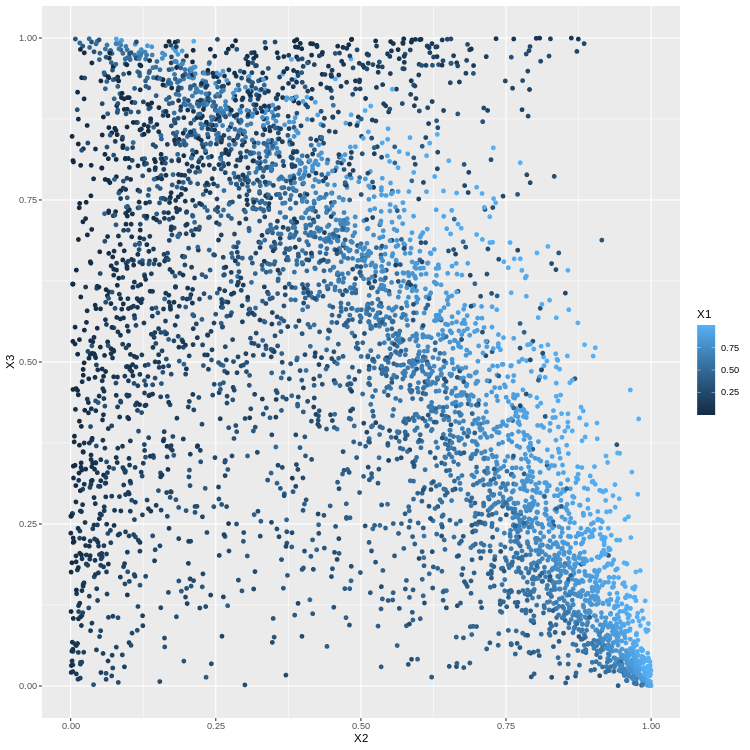

In [8]:
fit.data <- gamVineSimulate(5000,fit)
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 75)
ggpairs(data.frame(fit.data))
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 75)
ggplot(data.frame(fit.data), aes(X2,X3, col = X1)) + geom_point()

In [9]:
#Fitting simplified vine and visualizing it
rvinefit <- RVineCopSelect(sim.data,Matrix = Matrix)

$AIC
[1] -8750.728

$pair.AIC
          [,1]      [,2] [,3]
[1,]     0.000    0.0000    0
[2,] -4004.047    0.0000    0
[3,] -4114.498 -632.1832    0

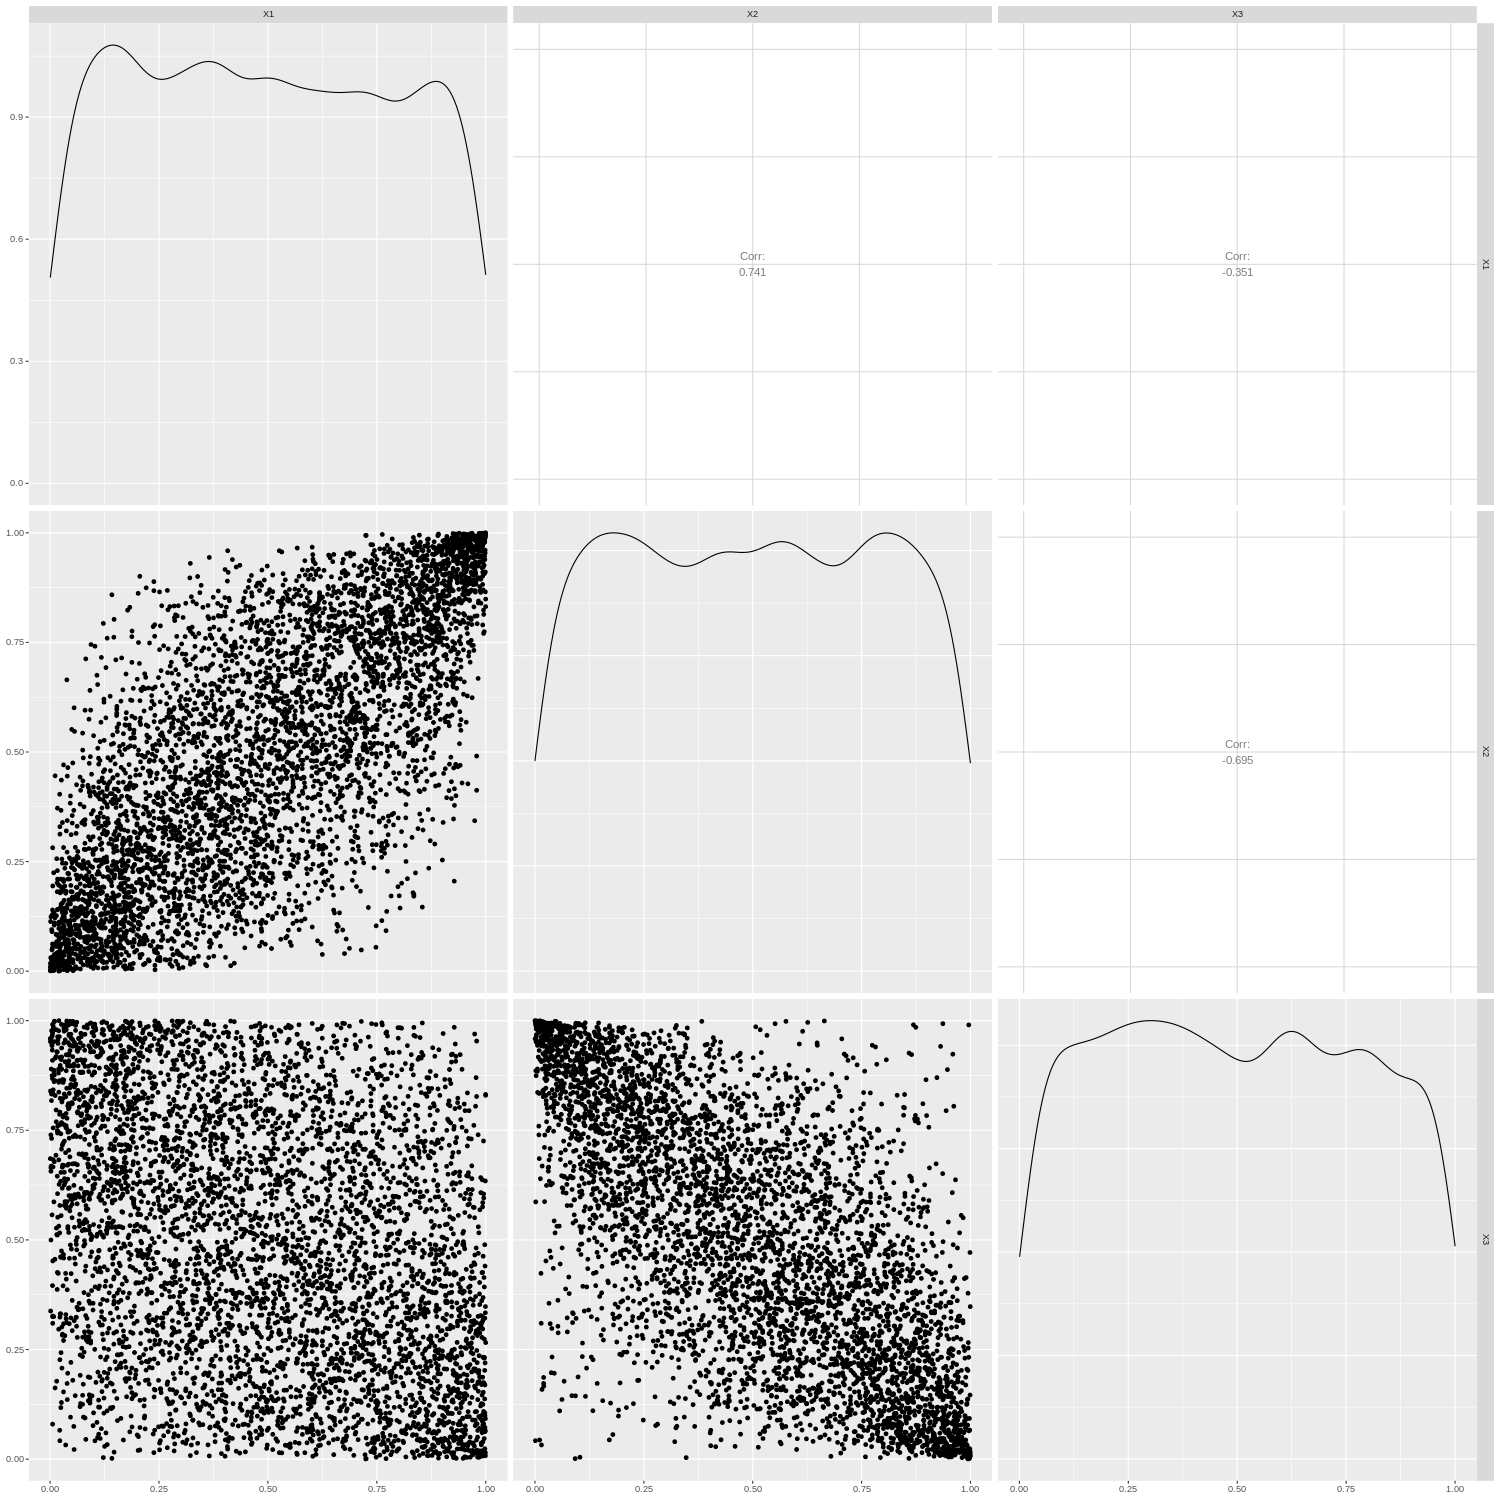

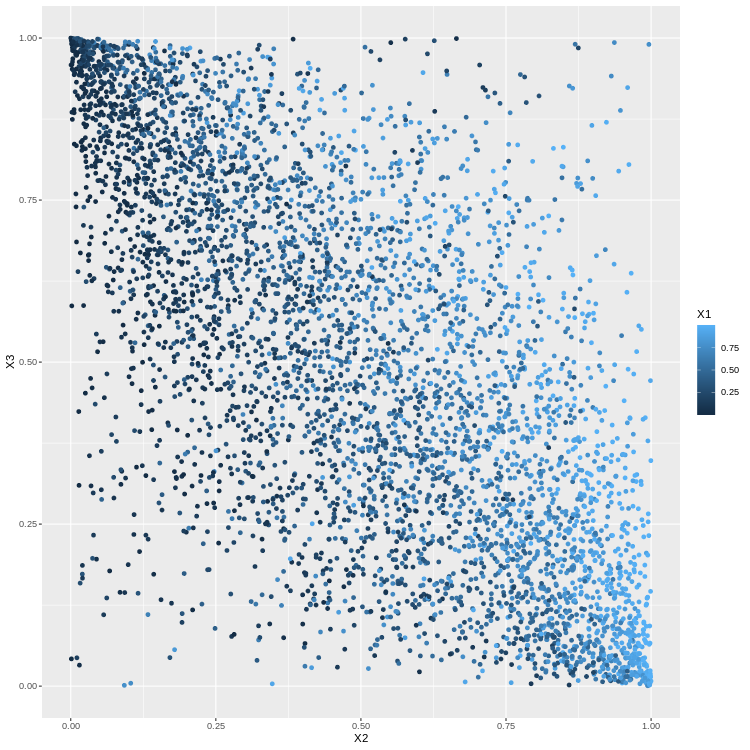

In [10]:
RVineAIC(sim.data,rvinefit)
rsim.data <- RVineSim(5000, rvinefit)
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 75)
ggpairs(data.frame(rsim.data))
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 75)
ggplot(data.frame(rsim.data), aes(X2,X3, col = X1)) + geom_point()

## Small script to simulate weird nonsimplified copulae

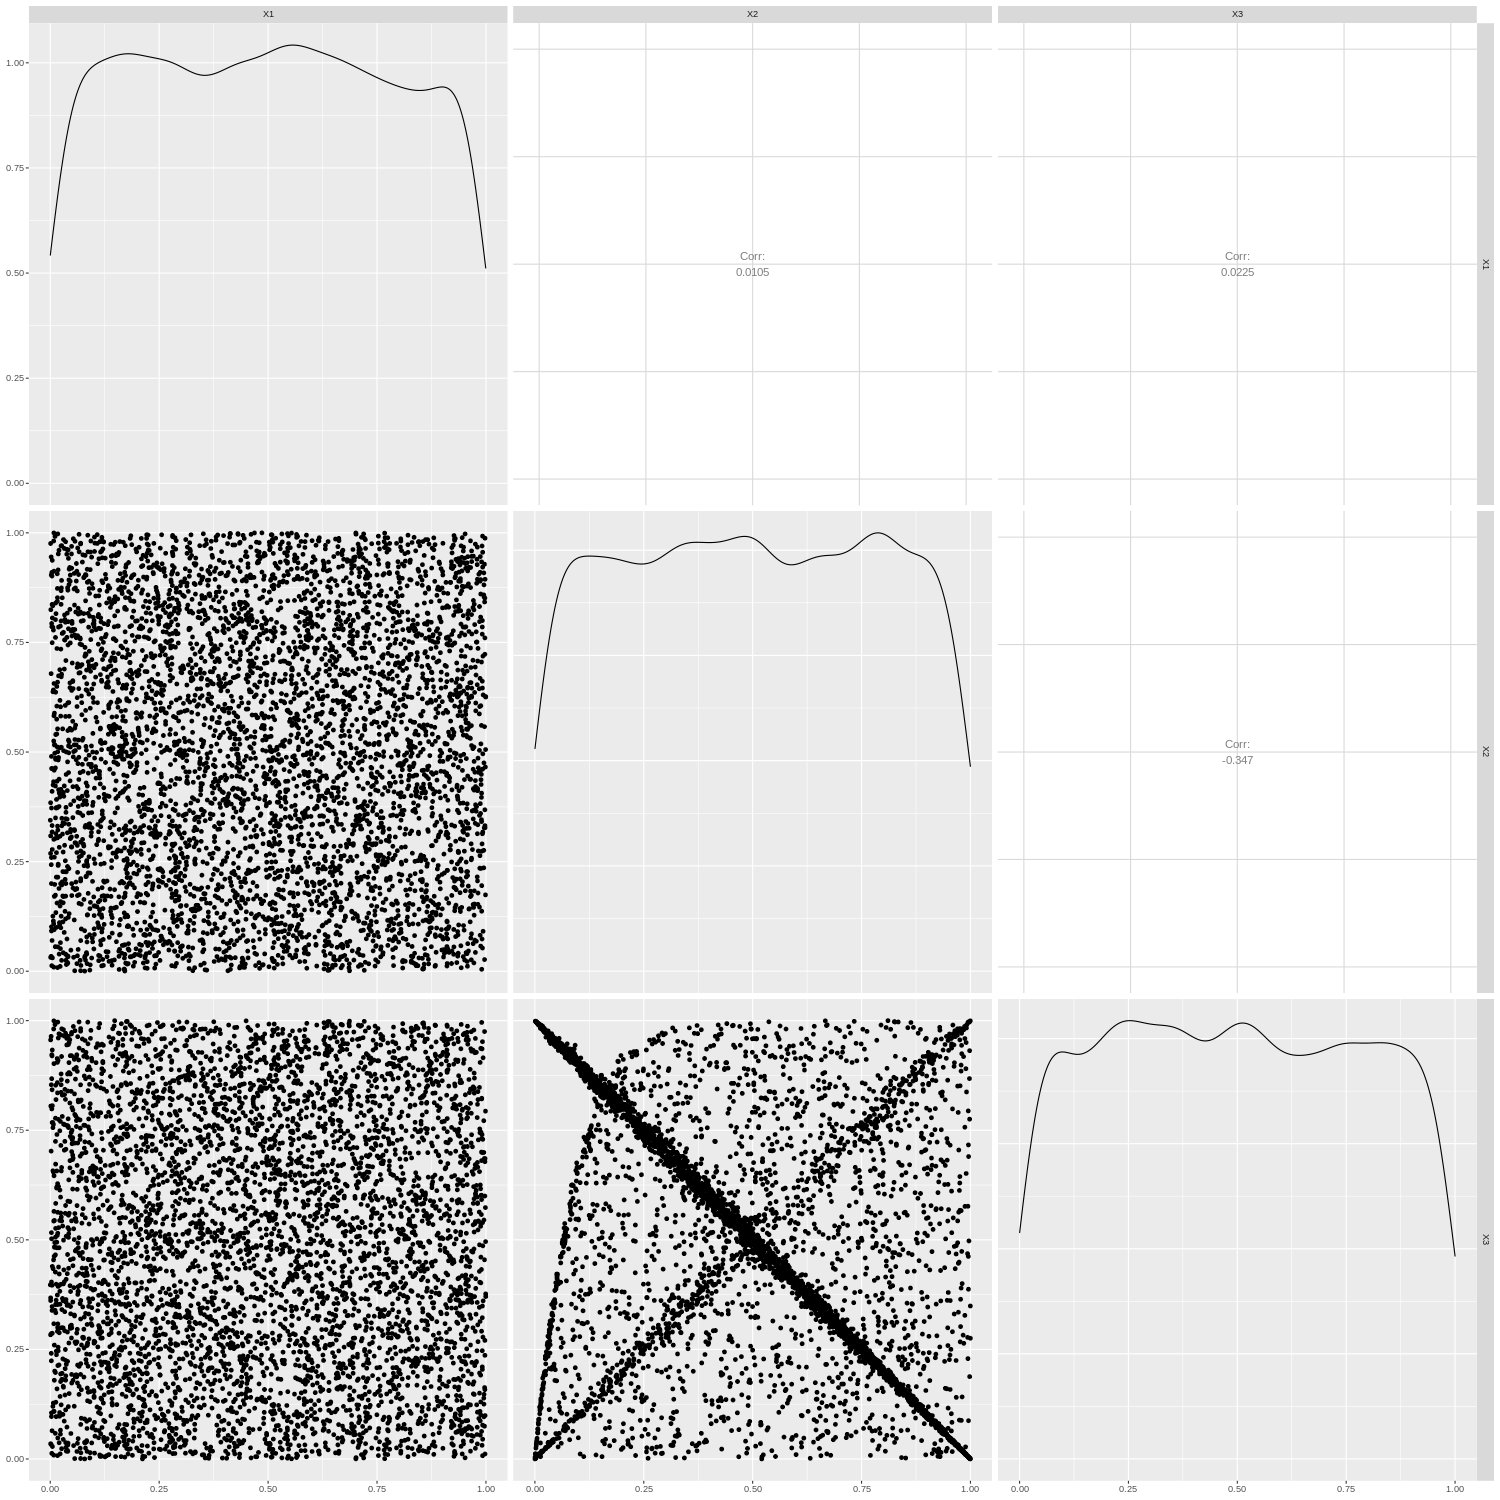

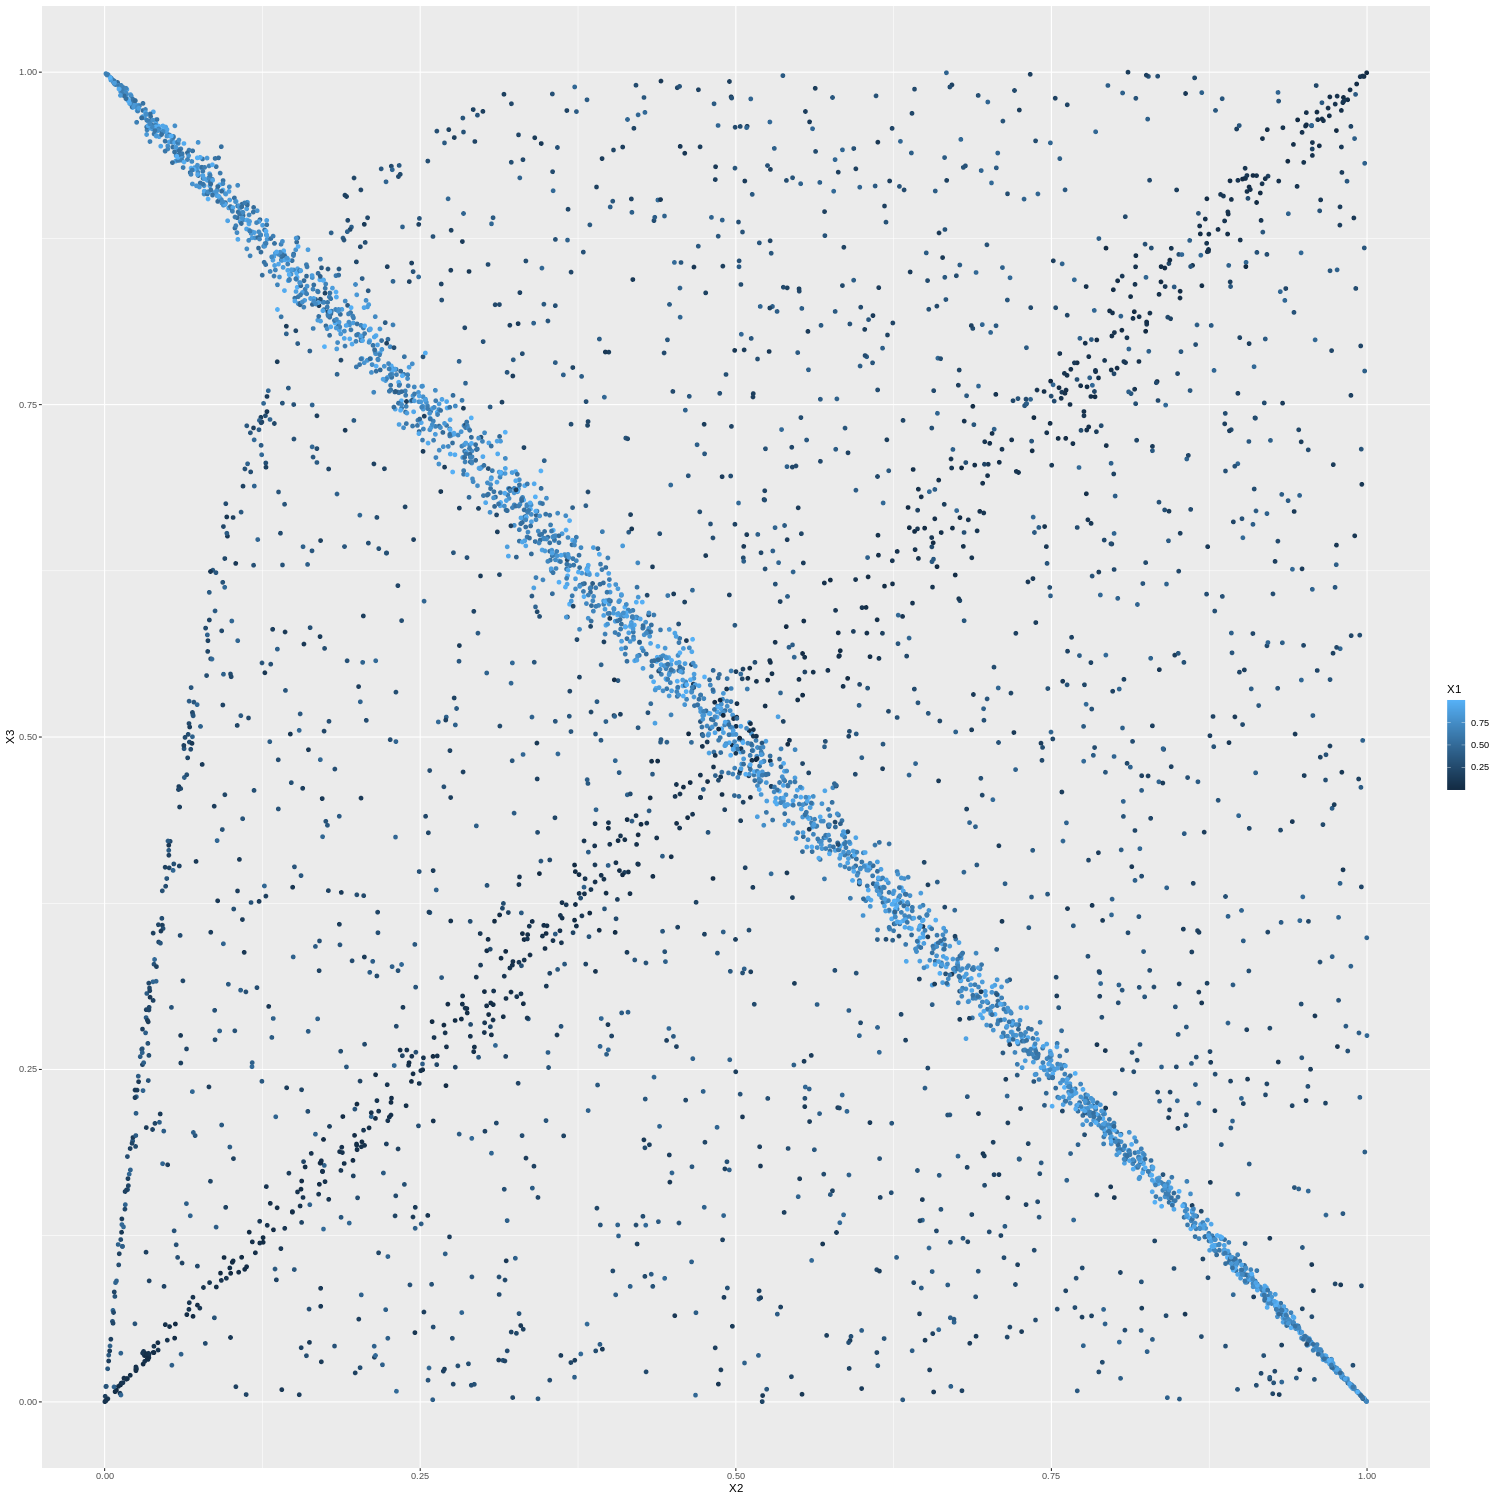

In [11]:
N = 5000
X = matrix(runif(3*N),N,3)

for (i in 1:N){
    if(X[i,1] < 0.1){
        X[i,3] <- BiCopCondSim(1, cond.val = X[i,2],cond.var = 1, family = 214, par = 20, par2 = 1)
    }
    else if(X[i,1] < 0.5){
        X[i,3] <- BiCopCondSim(1, cond.val = X[i,2],cond.var = 1, family = 214, par = 30, par2 = 0.1)
    }
    else {
        X[i,3] <- BiCopCondSim(1, cond.val = X[i,2],cond.var = 1, family = 34, par = -40)
    }
}

options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 75)
ggpairs(data.frame(X))
ggplot(data.frame(X), aes(X2,X3, col = X1)) + geom_point()
#fit <- gamVineCopSelect(X, Matrix, verbose = TRUE)

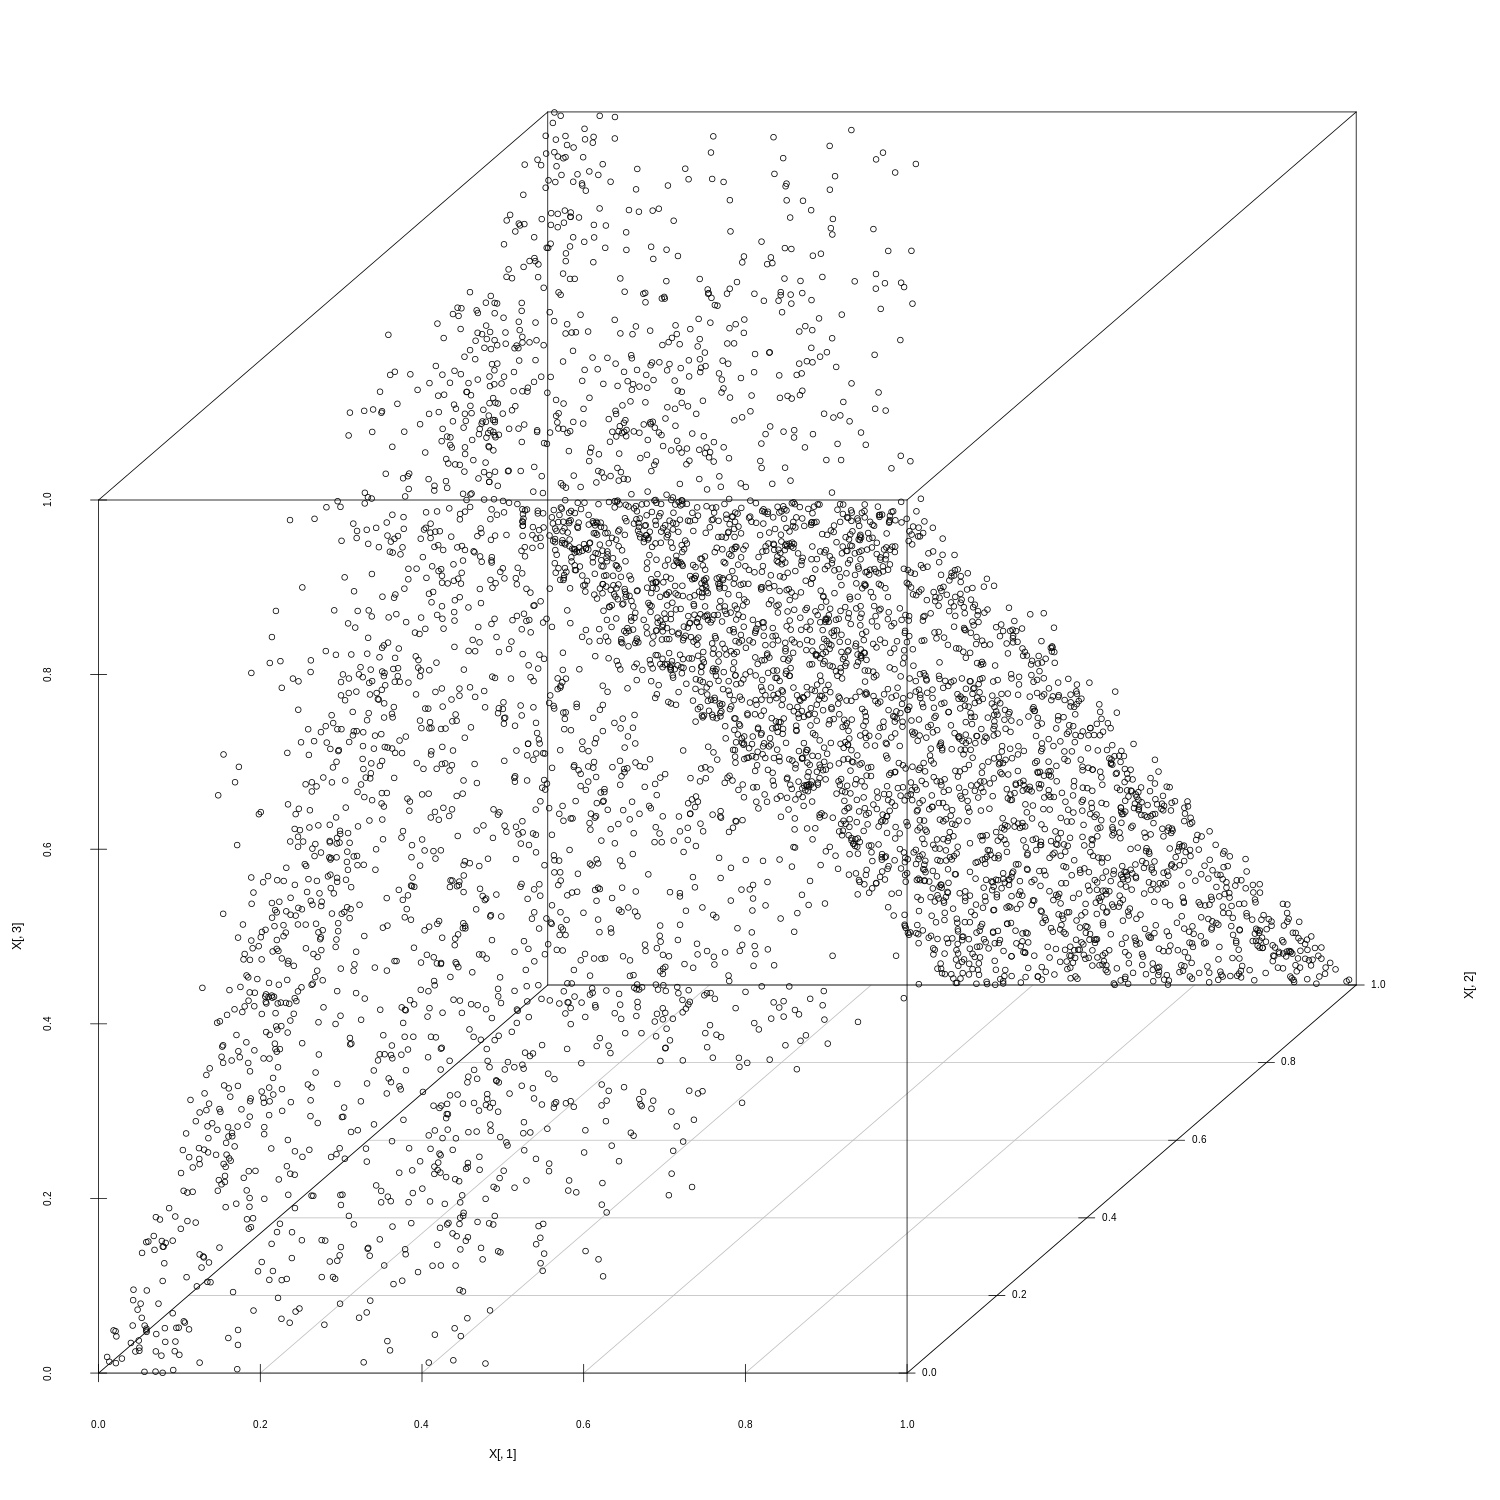

In [12]:
library('scatterplot3d')
scatterplot3d(X[,1],X[,2],X[,3])

In [13]:
pacotestOptions=pacotestset(testType='CCC')
Result = pacotest(X[,c(2,3)],X[,1],pacotestOptions)
Result$pValue

[1] 0

## Fitting gamVine to that weird data

In [14]:
fit <- gamVineCopSelect(X, Matrix, verbose = TRUE)  #Only the matrix is specified here
summary(fit)

3,1

2,1

2,3|1



GAM-Vine matrix: 
     [,1] [,2] [,3]
[1,]    2    0    0
[2,]    3    3    0
[3,]    1    1    1

 Where 
1  <->  V1 
2  <->  V2 
3  <->  V3 

 Tree 1: 
V2,V1: Independence 
V3,V1: Independence 

 Tree 2: 
V2,V3|V1 : Gumbel type 4 (survival and 270 degrees rotated) copula with tau(z) = (exp(z)-1)/(exp(z)+1) where 
Formula: 
 z ~ s(V1, k = 160, bs = "cr") 
  
 Parametric coefficients: 
             Estimate Std. Error t value Pr(>|t|)     
 (Intercept) -1.64058    0.01301  -126.1   <2e-16 *** 
 --- 
 Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
  
 Approximate significance of smooth terms: 
         edf Ref.df   F p-value     
 s(V1) 112.9  132.3 411  <2e-16 *** 
 --- 
 Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
  
 R-sq.(adj) =  0.915   Deviance explained = 91.8% 
 GCV = 0.90008  Scale est. = 0.87958   n = 5000 


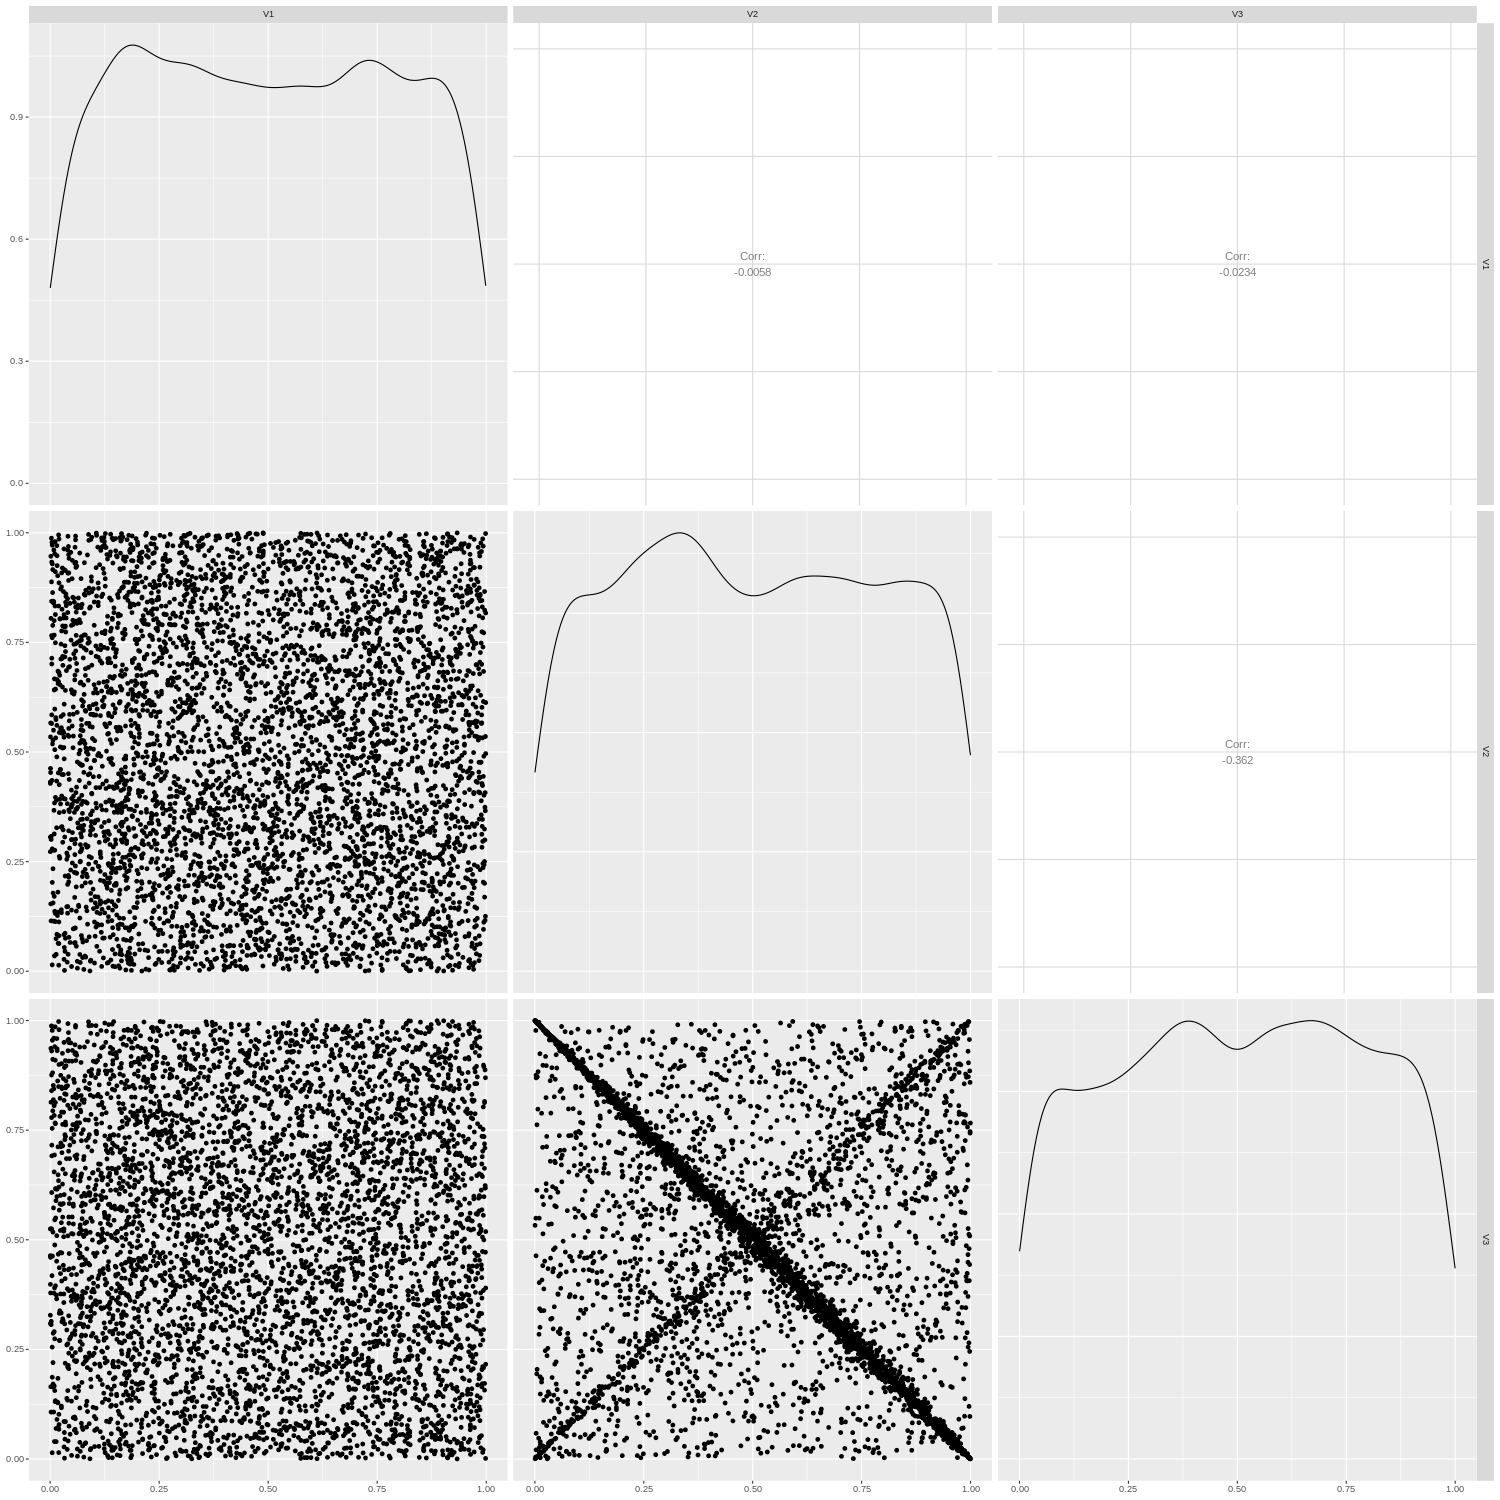

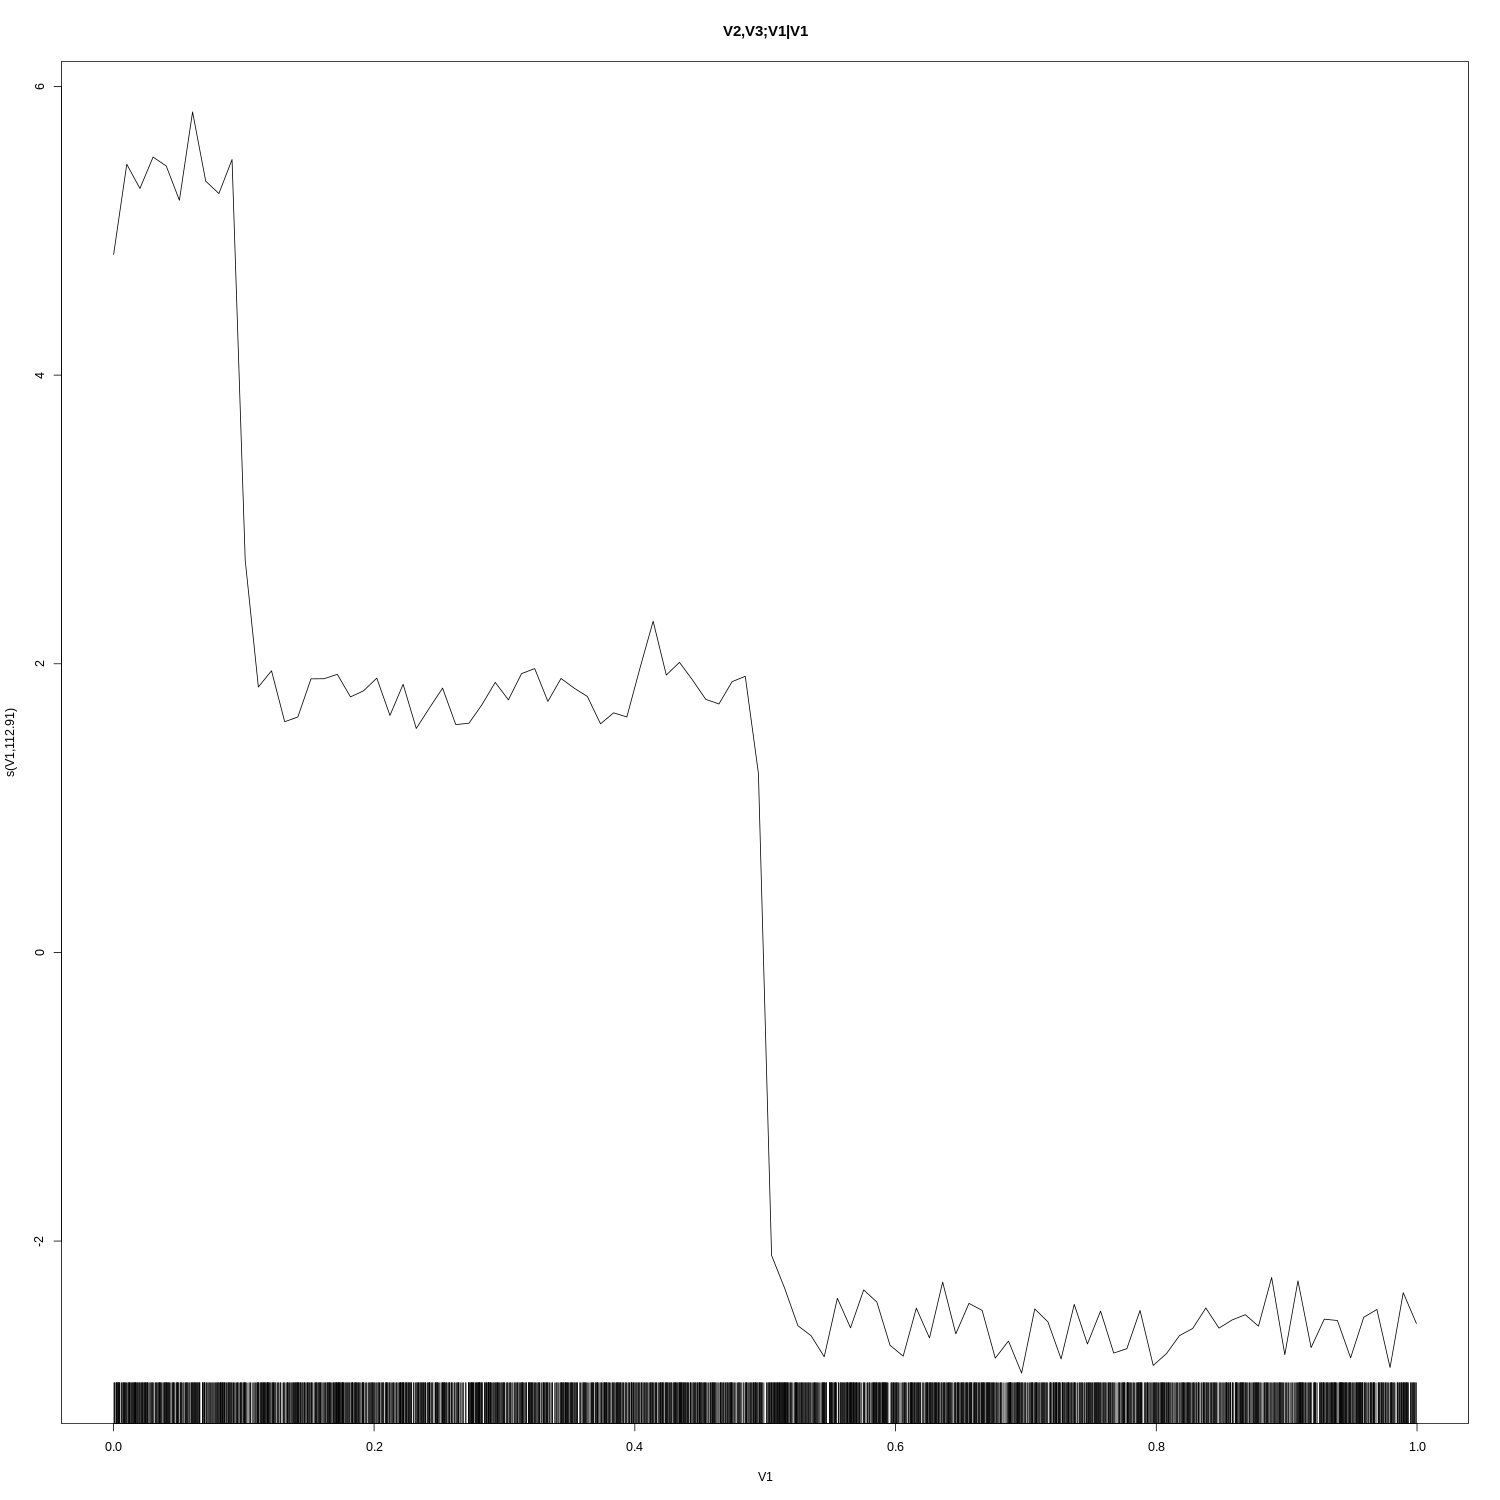

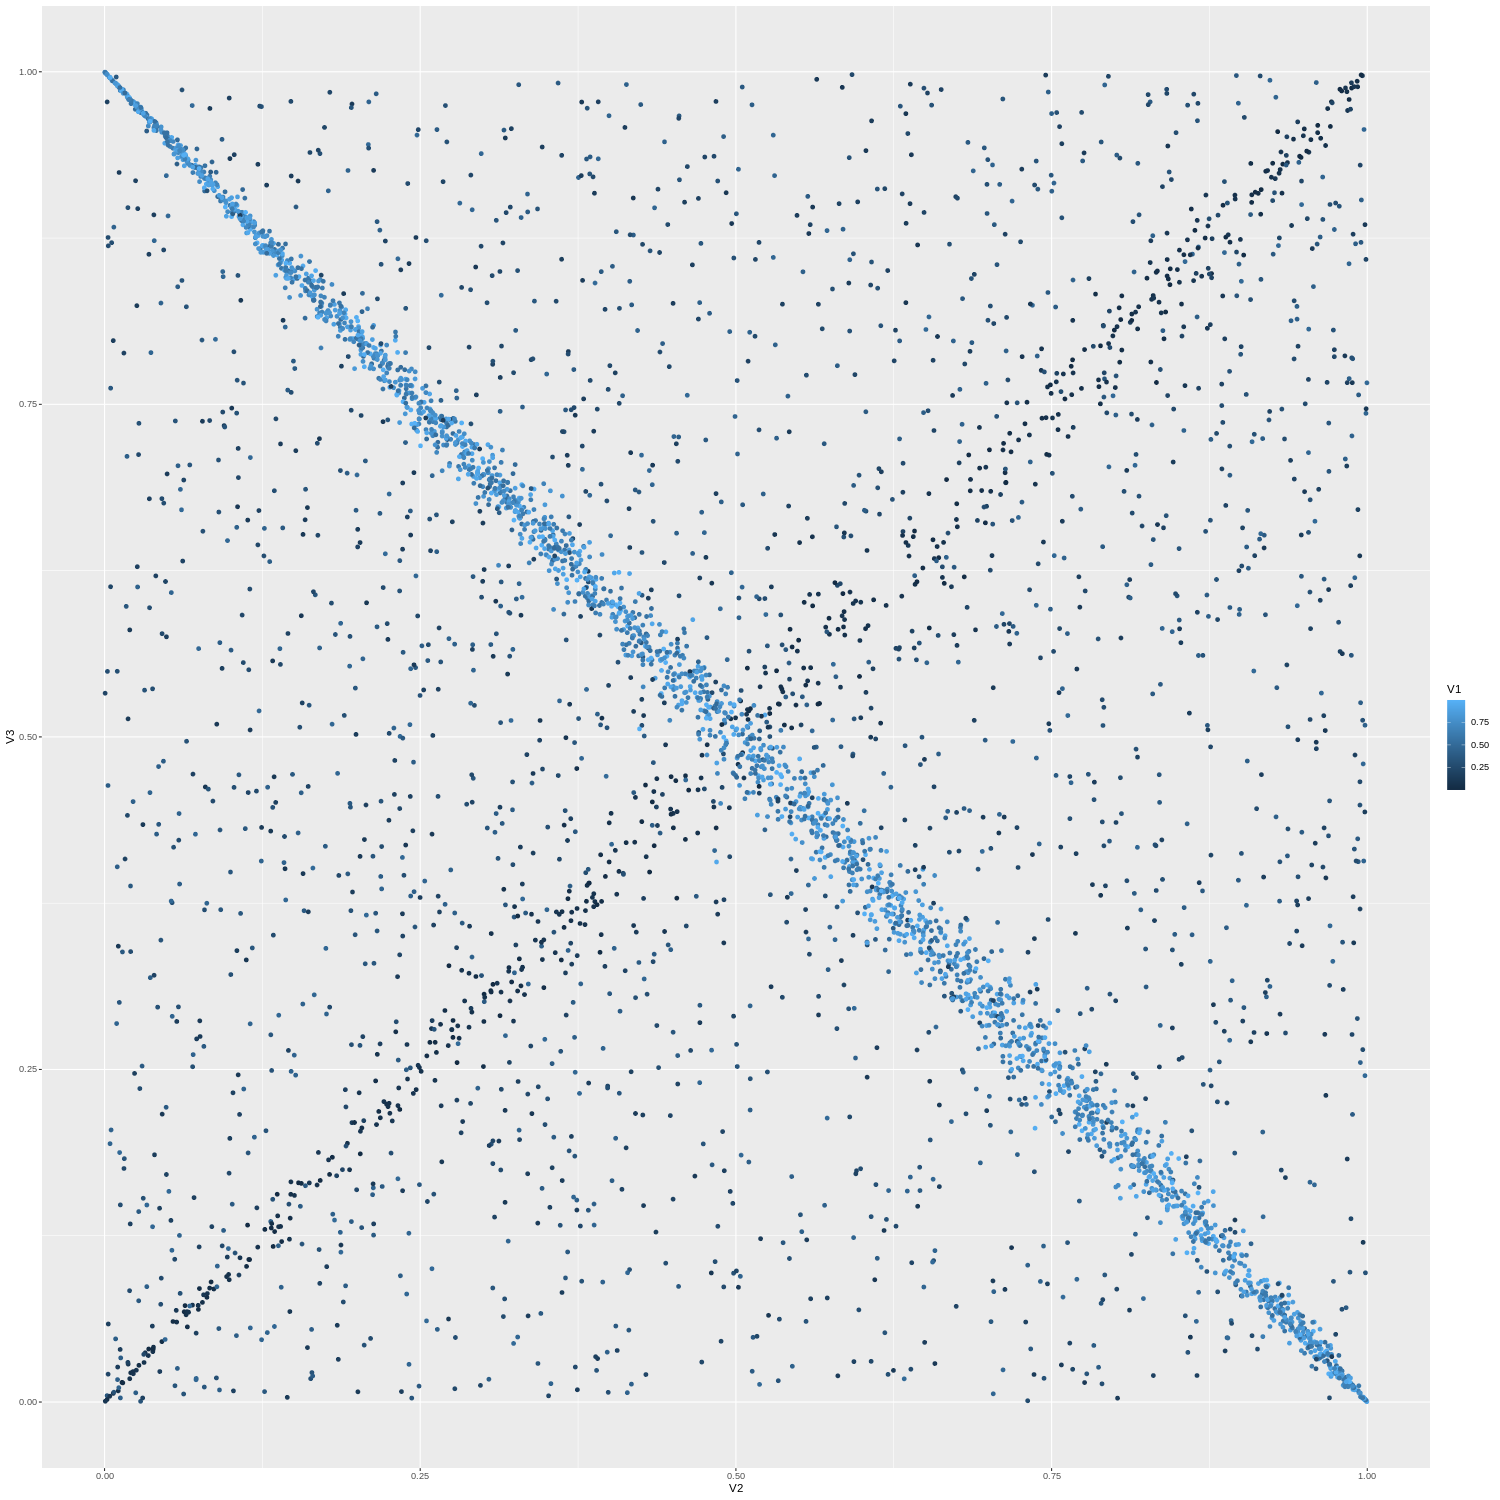

In [15]:
fit.data <- gamVineSimulate(5000,fit)
ggpairs(data.frame(fit.data))
plot(fit)
ggplot(data.frame(fit.data), aes(V2,V3, col = V1)) + geom_point()


## Moving to higher dimensions

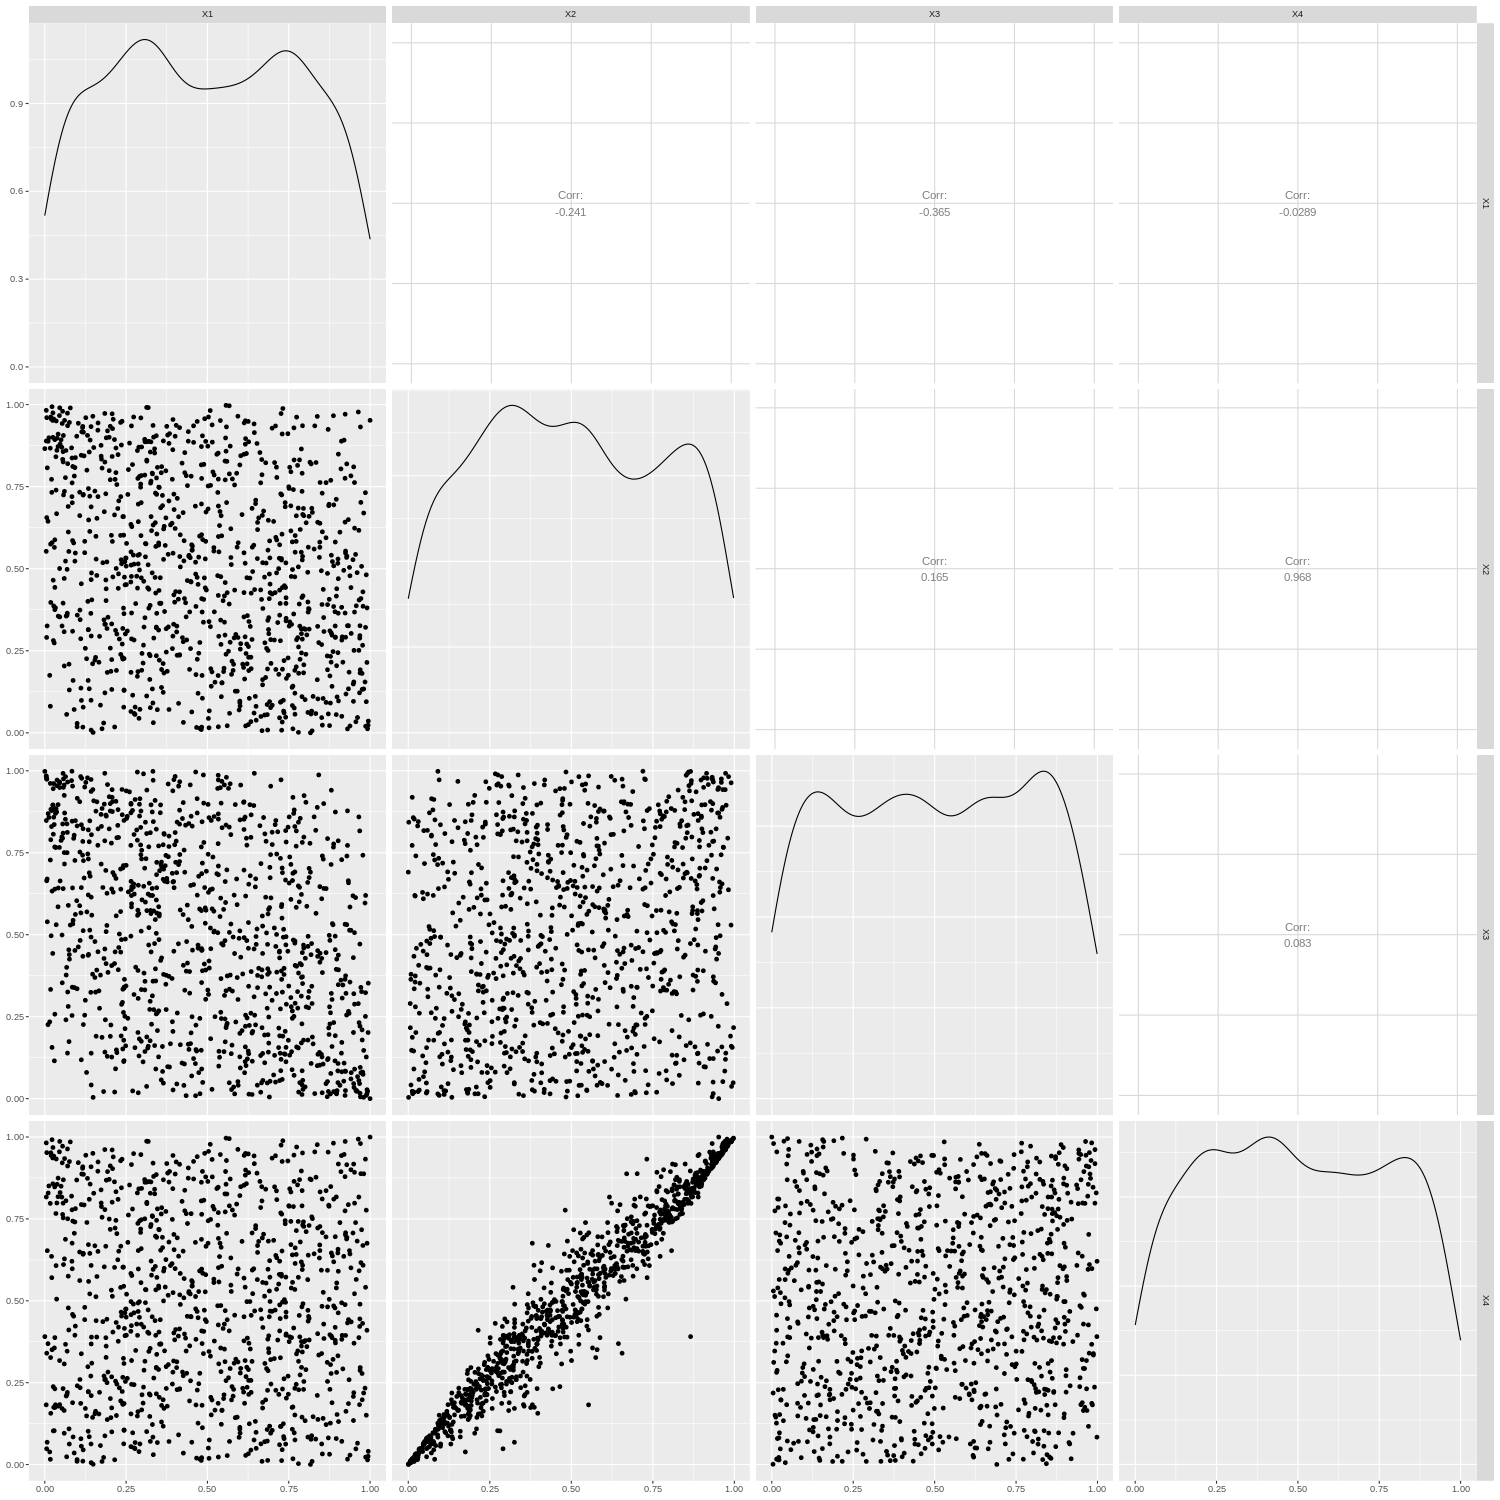

In [154]:
library('copula')
library('VineCopula')
library('gamCopula')
library('ggplot2')
library('mgcv')
library('pacotest')


d <- 4
Matrix <- c(2, 3, 4, 1, 0, 3, 4, 1, 0, 0, 4, 1, 0, 0, 0, 1)
Matrix <- matrix(Matrix, d, d)


dep.functions <- list(function(x) {return ((sin(pi*x^2)))},
                     function(x) {return ((-cos(x/0.1)))},
                     function(x) {return (exp(x)-4*x)})

#Plot the dependency functions
par(mfrow = c(2,2))
for (i in 1:length(dep.functions)) {
    plot(dep.functions[[i]], xlim = c(0,1), col = 'blue')
}

models <- vector(mode = 'list', length = d*(d-1)/2)
family.selection <- c(1,2,301,302,303,401,402,403) #Gauss, T, Double Claytons , Double Gumbels

#Model specification

#First Tree
models[[1]]$family <- 1 #Gaussian
models[[2]]$family <- 2 #T-Copula
models[[3]]$family <- 301 #Double Clayton type 1

models[[1]]$par <- runif(1,min = -1,max = 1)
models[[2]]$par <- runif(1, min = -1, max = 1)
models[[3]]$par <- runif(1,min = -10, max = 10)

models[[2]]$par2 <- 4

n.cov <- 100
tmp.stops <- seq(0,1,length.out = n.cov)

#Intermediate Tree
for (i in 4:5){
    tmp.fcts <- sample(1:length(dep.functions), 1)
    tmp.x <- tmp.stops
    tmp.y <- mapply(function(x) dep.functions[[tmp.fcts[1]]](x),
                    tmp.x)
    tmp.data <- data.frame(y = tmp.y, 'X1' = tmp.x)
    tmp.formula <- y ~ s(X1, k = 10, bs = 'cr')
    tmp.model <- gam(tmp.formula, data = tmp.data)
    tmp.family <- sample(family.selection,1)

    if (tmp.family ==2){
        tmp.par2 <- sample(2:10,1)
        models[[i]] <- gamBiCop(tmp.family, model = tmp.model, par2 = tmp.par2)
    } else{
        models[[i]] <- gamBiCop(tmp.family, model = tmp.model)
    }
}


#Final Tree
tmp.fcts <- sample(1:length(dep.functions), 2)
tmp.x <- expand.grid(tmp.stops, tmp.stops)
tmp.y <- mapply(function(x,y) dep.functions[[tmp.fcts[1]]](x) + dep.functions[[tmp.fcts[[2]]]](y),
                tmp.x[,1],tmp.x[,2])
tmp.data <- data.frame(y = tmp.y, 'X1' = tmp.x[,1], 'X4' = tmp.x[,2])
tmp.model <- gam(y ~ s(X1, k = 10, bs = 'cr') + s(X4, k = 10, bs = 'cr'), data = tmp.data)
tmp.family <- sample(family.selection,1)
if (tmp.family ==2){
    tmp.par2 <- sample(2:10,1)
    models[[6]] <- gamBiCop(tmp.family, model = tmp.model, par2 = tmp.par2)
} else{
    models[[6]] <- gamBiCop(tmp.family, model = tmp.model)
}

gvine <- gamVine(Matrix, models, names = c('X1','X2','X3','X4'))
print(gvine)